In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf

Loading data from drive

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/train.csv/train.csv")

testText = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test.csv/test.csv')
testLevel = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/jigsaw-toxic-comment-classification-challenge/test_labels.csv/test_labels.csv")

In [ ]:
print("Shape of train data: ", train.shape)
print("Shape of test data: ", testText.shape)

Shape of train data:  (159571, 8)
Shape of test data:  (153164, 2)


In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [ ]:
testText.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


In [ ]:
testLevel.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1


In [ ]:
test = pd.merge(testText,testLevel, on='id')
test = test[test['toxic']!=-1]
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,Thank you for understanding. I think very high...,0,0,0,0,0,0
7,000247e83dcc1211,:Dear god this site is horrible.,0,0,0,0,0,0
11,0002f87b16116a7f,"""::: Somebody will invariably try to add Relig...",0,0,0,0,0,0
13,0003e1cccfd5a40a,""" \n\n It says it right there that it IS a typ...",0,0,0,0,0,0
14,00059ace3e3e9a53,""" \n\n == Before adding a new product to the l...",0,0,0,0,0,0


In [ ]:
test.shape

(63978, 8)

In [ ]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train.iloc[6]['comment_text']

'COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK'

In [ ]:
train[train.columns[2:]].iloc[6]

toxic            1
severe_toxic     1
obscene          1
threat           0
insult           1
identity_hate    0
Name: 6, dtype: int64

Visualzing the data

<ipython-input-5-b8bd4b0944ea>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(comment_len,kde=False, color="blue")


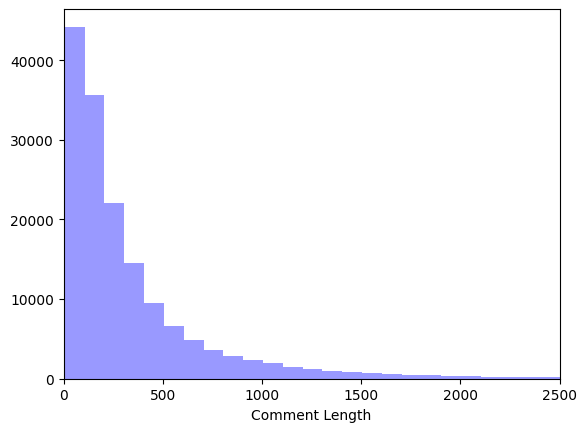

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# sns.set(color_codes=True)
comment_len = train.comment_text.str.len()
sns.distplot(comment_len,kde=False, color="blue")
plt.xlim(0, 2500)

plt.xlabel('Comment Length')

# Display the plot
plt.show()

We can see most of the comments have short length and very few have length grater than 1000

Plotting the correlational matrix

<Axes: >

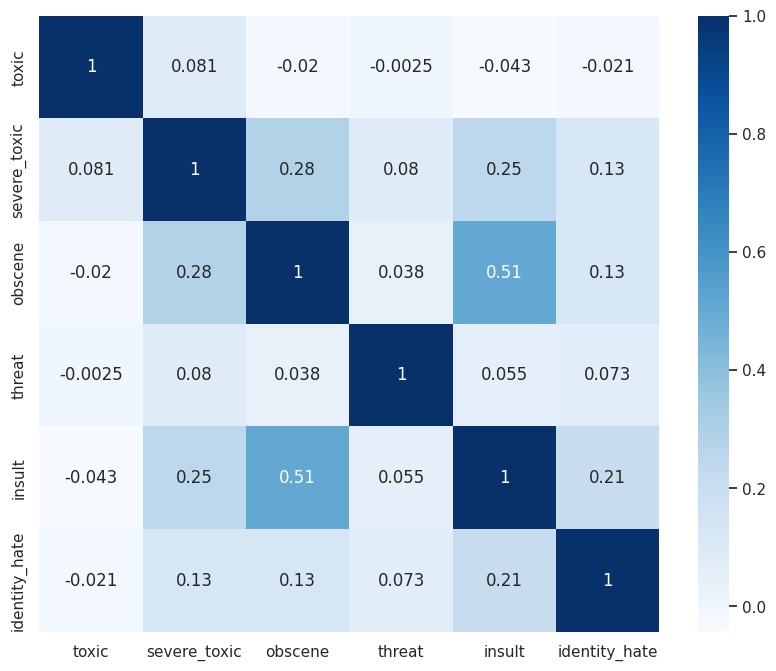

In [ ]:
rowsums = train.iloc[:, 2:8].sum(axis=1)
temp = train.iloc[:, 2:8]
train_corr = temp[rowsums > 0]
corr = train_corr.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True, cmap="Blues")

The highest levels of correlation can
be observed between the obscene and toxic

Preprocessing the data



1.   Removing Characters in between Text.
2. Removing Repeated Characters.

1.   Converting data to lower-case.
2.   Removing Punctuation.
3.   Removing unnecessary white spaces in between words.
2.   Removing “\n”.
3. Removing Non-English characters.





In [ ]:
import re

def clean_text(text,remove_repeat_text=True, is_lower=True):

  if is_lower:
    text=text.lower()

  if remove_repeat_text:
    text = re.sub(r'(.)\1{2,}', r'\1', text)  #removes repeated characters.
    # uses regular expressions (re) to find consecutive occurrences of a character
    # and replaces them with a single instance of that character.
    # For example, it replaces "loooove" with "love" by reducing consecutive repeated characters to a single occurrence

  text = str(text).replace("\n", " ") #replaces newline characters (\n) with a space character
  text = re.sub(r'[^\w\s]',' ',text) #substitute any non-alphanumeric and non-whitespace characters with a space character.
  text = re.sub('[0-9]',"",text) #remove any numeric digits from the text
  text = re.sub(" +", " ", text) #replace multiple consecutive spaces with a single space
  text = re.sub("([^\x00-\x7F])+"," ",text) #remove any non-ASCII characters from the text
  return text

In [ ]:
train['comment_text'] = train['comment_text'].apply(clean_text)
test['comment_text'] = test['comment_text'].apply(clean_text)

In [ ]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits made under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,d aww he matches this background colour i m se...,0,0,0,0,0,0
2,000113f07ec002fd,hey man i m really not trying to edit war it s...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i can t make any real suggestions on imp...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir are my hero any chance you remember wh...,0,0,0,0,0,0


In [ ]:
test.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,thank you for understanding i think very highl...,0,0,0,0,0,0
7,000247e83dcc1211,dear god this site is horrible,0,0,0,0,0,0
11,0002f87b16116a7f,somebody will invariably try to add religion ...,0,0,0,0,0,0
13,0003e1cccfd5a40a,it says it right there that it is a type the ...,0,0,0,0,0,0
14,00059ace3e3e9a53,before adding a new product to the list make ...,0,0,0,0,0,0


Removing Stopwords using NLTK stopwords

In [ ]:
import nltk
from nltk.corpus import stopwords

In [ ]:
nltk.download('stopwords')
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
testText.shape

(153164, 2)

In [ ]:
from tqdm.notebook import tqdm_notebook

In [ ]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text, remove_stop=True):
  output = ""
  if remove_stop:
    text=text.split(" ")
    for word in text:
      if word not in stop_words:
        output=output + " " + word
  else :
    output=text

  return str(output.strip())

#Removing Stopwords from Training Data
processed_train_data = []
for line in train["comment_text"]:
    processed_train_data.append(remove_stopwords(line))

#Removing Stopwords from Test Data
processed_test_data = []
for line in test["comment_text"]:
    processed_test_data.append(remove_stopwords(line))

In [ ]:
processed_train_data[0]

'explanation edits made username hardcore metallica fan reverted vandalisms closure gas voted new york dolls fac please remove template talk page since retired'

In [ ]:
processed_test_data[0]

'thank understanding think highly would revert without discussion'

In [ ]:
train["comment_text"] = processed_train_data
test["comment_text"] = processed_test_data
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0
1,000103f0d9cfb60f,aww matches background colour seemingly stuck ...,0,0,0,0,0,0
2,000113f07ec002fd,hey man really trying edit war guy constantly ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0
4,0001d958c54c6e35,sir hero chance remember page,0,0,0,0,0,0


Tokenization

In [ ]:
CATEGORIES = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

X_train = train["comment_text"]
y_train = train[CATEGORIES].values
X_test = test['comment_text']
y_test = test[CATEGORIES].values
X_train

0         explanation edits made username hardcore metal...
1         aww matches background colour seemingly stuck ...
2         hey man really trying edit war guy constantly ...
3         make real suggestions improvement wondered sec...
4                             sir hero chance remember page
                                ...                        
159566    second time asking view completely contradicts...
159567                 ashamed horrible thing put talk page
159568    spitzer umm theres actual article prostitution...
159569    looks like actually put speedy first version d...
159570    really think understand came idea bad right aw...
Name: comment_text, Length: 159571, dtype: object

In [ ]:
y_train[6]

array([1, 1, 1, 0, 1, 0])

In [ ]:
from keras.preprocessing.text import Tokenizer

max_features=100000

tokenizer = Tokenizer(num_words=max_features,oov_token='<nothing>')
tokenizer.fit_on_texts(X_train)


In [ ]:
tokenizer.word_index['the']

2183

Padding the sequence

In [ ]:
from keras.utils import pad_sequences
maxpadlen = 500


In [ ]:
def tokenization(data):
  data = tokenizer.texts_to_sequences(data)
  data=pad_sequences(data, maxlen=maxpadlen, padding = 'post')
  return data

In [ ]:
X_train = tokenization(X_train)
X_test = tokenization(X_test)

In [ ]:
X_train

array([[  532,    47,    49, ...,     0,     0,     0],
       [15302,  2372,   420, ...,     0,     0,     0],
       [  284,   294,    53, ...,     0,     0,     0],
       ...,
       [29860,  6823,  4757, ...,     0,     0,     0],
       [  434,     9,   111, ...,     0,     0,     0],
       [   53,    12,   147, ...,     0,     0,     0]], dtype=int32)

BAKI
Fast text embedding
model building
ml flow
paramater tuing

In [ ]:
X_train.shape

(159571, 500)

In [ ]:
X_test.shape

(63978, 500)

Initaialing the word embedding using Sentence Transformer

Importing sentence transformer

In [ ]:
# !pip install sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 33.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 90.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.9 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=3ebd206aee087aa604d6027a6fe768b3500843260c2e8e86523e6e896d180ae9
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
# from sentence_transformers import SentenceTransformer

# model_name = 'all-MiniLM-L6-v2'
# sentence_transformer_model = SentenceTransformer(model_name)

In [ ]:
# Converting sequences back to sentences
# sentences = tokenizer.sequences_to_texts(X_train)

# Obtaining sentence embeddings using the Sentence Transformer model
# sentence_embeddings = sentence_transformer_model.encode(sentences)

Saving the sentence_embedding in drive

In [ ]:
# df_embeddings = pd.DataFrame(sentence_embeddings)
# df_embeddings.to_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv', index=False)

In [ ]:
# type(sentence_embeddings)

numpy.ndarray

Directly load the embedded sentences

In [ ]:
loaded_df_embeddings = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sentence_embeddings.csv')
sentence_embeddings = loaded_df_embeddings.values

Creating a LSTM model

In [ ]:
import tensorflow
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense

In [ ]:
num_classes = 6
epochs = 10
batch_size = 64

In [ ]:

# lstm_model = Sequential()

# embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
#                             output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
#                             weights=[sentence_embeddings],  # Use the loaded embeddings
#                             input_length=maxpadlen,
#                             trainable=False)  # Freeze the embeddings

# lstm_model.add(embedding_layer)
# lstm_model.add(LSTM(units=64, return_sequences=True))
# lstm_model.add(LSTM(units=32))
# lstm_model.add(Dense(units=num_classes, activation='sigmoid'))  # Output layer for multi-label classification

# # Compiling the model
# lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])



In [ ]:
from keras.models import Model
from keras.layers import *

In [ ]:
inp=Input(shape=(maxpadlen, ),dtype='int32')
embedding_layer = Embedding(input_dim=sentence_embeddings.shape[0],  # Number of words in the vocabulary
                            output_dim=sentence_embeddings.shape[1],  # Size of the embeddings
                            weights=[sentence_embeddings],  # Use the loaded embeddings
                            input_length=maxpadlen,
                            trainable=False)  # Freeze the embeddings
embedded_sequences = embedding_layer(inp)
x = LSTM(50, return_sequences=True,name='lstm_layer')(embedded_sequences)
x = GlobalMaxPool1D()(x)
x = Dropout(0.2)(x)
x = Dense(40, activation="relu", kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)
preds = Dense(6, activation="sigmoid", kernel_initializer='glorot_uniform')(x)

#Compile the Model.
lstm_model = Model(inputs=inp, outputs=preds)

lstm_model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])


In [ ]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 384)          61275264  
                                                                 
 lstm_layer (LSTM)           (None, 500, 50)           87000     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 40)                2040      
                                                             

In [ ]:
from keras.utils import plot_model

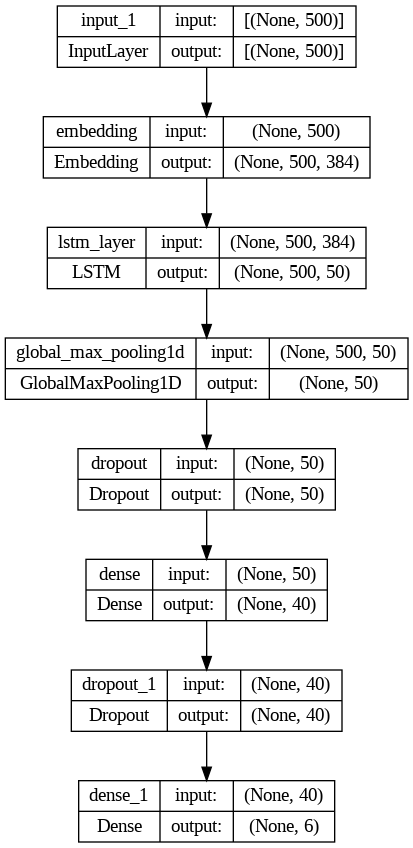

In [ ]:
plot_model(lstm_model, show_shapes=True)

In [ ]:
y_train

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
# Training the LSTM model
# lstm_model_info=lstm_model.fit(X_train,y_train, epochs=epochs, batch_size=batch_size,  validation_data = (X_test, y_test))

Epoch 1/10
2494/2494 [==============================] - 71s 25ms/step - loss: 0.1113 - accuracy: 0.8999 - val_loss: 0.0965 - val_accuracy: 0.9976
Epoch 2/10
2494/2494 [==============================] - 63s 25ms/step - loss: 0.0749 - accuracy: 0.9939 - val_loss: 0.0820 - val_accuracy: 0.9976
Epoch 3/10
2494/2494 [==============================] - 57s 23ms/step - loss: 0.0667 - accuracy: 0.9942 - val_loss: 0.0791 - val_accuracy: 0.9976
Epoch 4/10
2494/2494 [==============================] - 57s 23ms/step - loss: 0.0624 - accuracy: 0.9942 - val_loss: 0.0749 - val_accuracy: 0.9976
Epoch 5/10
2494/2494 [==============================] - 59s 24ms/step - loss: 0.0598 - accuracy: 0.9942 - val_loss: 0.0801 - val_accuracy: 0.9976
Epoch 6/10
2494/2494 [==============================] - 59s 24ms/step - loss: 0.0571 - accuracy: 0.9941 - val_loss: 0.0740 - val_accuracy: 0.9976
Epoch 7/10
2494/2494 [==============================] - 59s 24ms/step - loss: 0.0559 - accuracy: 0.9941 - val_loss: 0.0812 -

Saving the LSTM model

In [ ]:
# lstm_model.save('/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/simple_lstm_model')

Loading pretrained LSTM model from drive

In [ ]:
from keras.models import load_model

lstm_model = load_model("/content/drive/MyDrive/Colab Notebooks/Toxic_comments_models/simple_lstm_model")

In [ ]:
lstm_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding (Embedding)       (None, 500, 384)          61275264  
                                                                 
 lstm_layer (LSTM)           (None, 500, 50)           87000     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 40)                2040      
                                                             

Testing our model on testing dataset

In [ ]:
y_test_pred = lstm_model.predict(X_test)

2000/2000 [==============================] - 15s 7ms/step


In [ ]:
y_test_pred

array([[2.8364107e-02, 1.2528172e-04, 4.6131331e-03, 3.7835914e-04,
        6.3911784e-03, 1.0075907e-03],
       [2.0643361e-01, 5.5702818e-03, 6.5690719e-02, 9.2274873e-03,
        8.1175461e-02, 1.6996739e-02],
       [7.4510716e-02, 4.7254039e-04, 1.6273513e-02, 9.7922096e-04,
        2.3071641e-02, 2.5647299e-03],
       ...,
       [6.8793461e-02, 9.2598202e-04, 1.5427492e-02, 2.2044857e-03,
        2.2089101e-02, 4.5779604e-03],
       [9.8131865e-01, 1.6999421e-01, 9.0711367e-01, 4.4246703e-02,
        7.3562568e-01, 1.4395796e-01],
       [3.0953921e-02, 1.6554272e-04, 5.5125644e-03, 5.0572382e-04,
        7.5787939e-03, 1.1938211e-03]], dtype=float32)

In [ ]:
threshold = 0.5
y_test_pred_labels = (y_test_pred > threshold).astype(int)
print(y_test_pred_labels)

[[0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 ...
 [1 0 0 0 0 0]
 [1 0 1 0 1 0]
 [0 0 0 0 0 0]]


Evaluating

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Create a DataFrame from the y_test NumPy array
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y_test_df = pd.DataFrame(y_test, columns=class_names)
y_pred_df = pd.DataFrame(y_test_pred_labels, columns=class_names)

# Display the DataFrame
print(y_pred_df)

       toxic  severe_toxic  obscene  threat  insult  identity_hate
0          0             0        0       0       0              0
1          0             0        0       0       0              0
2          0             0        0       0       0              0
3          0             0        0       0       0              0
4          0             0        0       0       0              0
...      ...           ...      ...     ...     ...            ...
63973      0             0        0       0       0              0
63974      1             0        0       0       1              0
63975      1             0        0       0       0              0
63976      1             0        1       0       1              0
63977      0             0        0       0       0              0

[63978 rows x 6 columns]


In [ ]:
def evaluation(prediction, actual, col):
  accuracy = accuracy_score(actual[col], prediction[col])
  f1 = f1_score(actual[col], prediction[col], average='weighted')
  recall = recall_score(actual[col], prediction[col], average='weighted')
  precision = precision_score(actual[col], prediction[col], average='weighted')

  print("Accuracy of ",col , " is: " ,accuracy)
  print("F1-score of",col , " is: " ,f1)
  print("Recall of",col , " is: " ,recall)
  print("Precision of",col , " is: " ,precision)

  # Plot the confusion matrix
def plot_confusion(prediction, actual, col):
  cm = confusion_matrix(actual[col], prediction[col])
  classes = [col]

  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predicted Labels')
  plt.ylabel('True Labels')
  plt.title('Confusion Matrix')
  plt.show()

In [ ]:
for name in class_names:
  evaluation(actual=y_test_df, prediction=y_pred_df, col = name)
  print("\n")


Accuracy of  toxic  is:  0.9161430491731533
F1-score of toxic  is:  0.9234434558312636
Recall of toxic  is:  0.9161430491731533
Precision of toxic  is:  0.9372397179462404


Accuracy of  severe_toxic  is:  0.9942636531307637
F1-score of severe_toxic  is:  0.9927241092727545
Recall of severe_toxic  is:  0.9942636531307637
Precision of severe_toxic  is:  0.9922747735845965


Accuracy of  obscene  is:  0.9566569758354434
F1-score of obscene  is:  0.9591673202588652
Recall of obscene  is:  0.9566569758354434
Precision of obscene  is:  0.9630418660288379


Accuracy of  threat  is:  0.9967019913095126
F1-score of threat  is:  0.995055710671004
Recall of threat  is:  0.9967019913095126
Precision of threat  is:  0.9934148594803478


Accuracy of  insult  is:  0.9552971333896026
F1-score of insult  is:  0.9572832545845649
Recall of insult  is:  0.9552971333896026
Precision of insult  is:  0.9599399769666788


Accuracy of  identity_hate  is:  0.9905279939979368
F1-score of identity_hate  is:  0.9

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


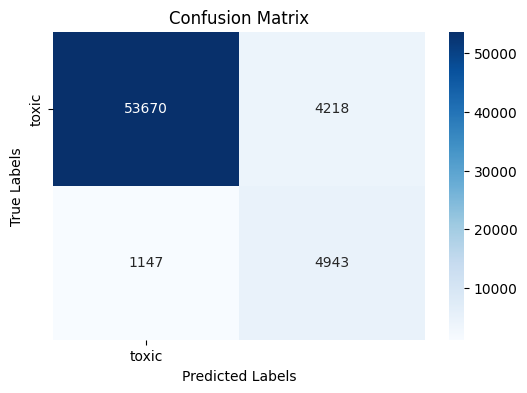

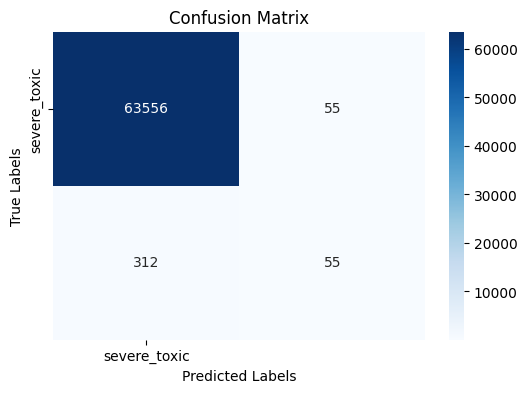

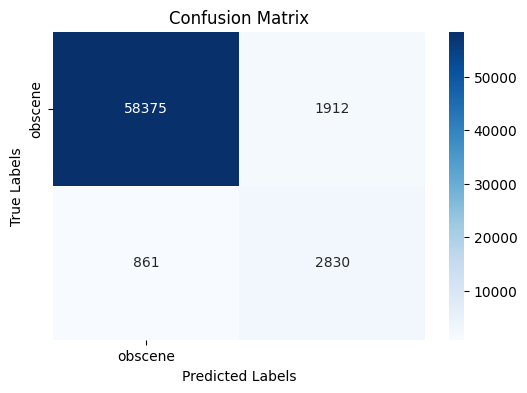

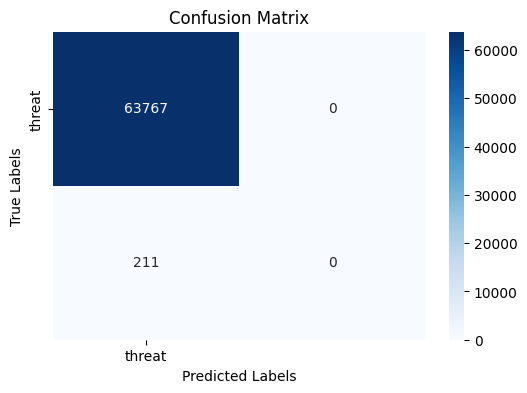

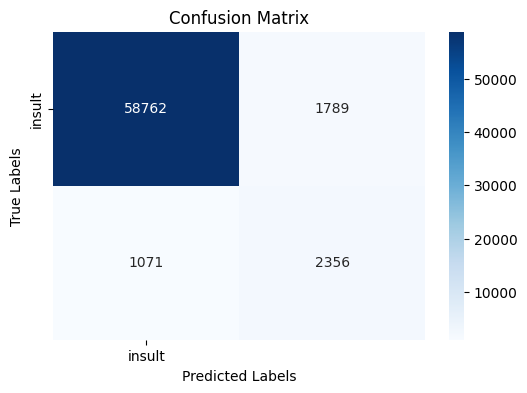

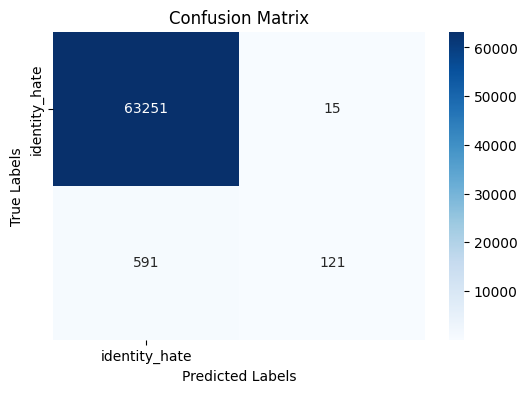

In [ ]:
for name in class_names:
  plot_confusion(actual=y_test_df, prediction=y_pred_df, col = name)


Calculating the overal model performance by flattening the dataframe

In [ ]:
y_true_flat = y_test.ravel()
y_pred_flat = y_test_pred_labels.ravel()
accuracy = accuracy_score(y_true_flat, y_pred_flat)
f1 = f1_score(y_true_flat, y_pred_flat, average='weighted')
recall = recall_score(y_true_flat, y_pred_flat, average='weighted')
precision = precision_score(y_true_flat, y_pred_flat, average='weighted')

print("Accuracy is: " ,accuracy)
print("F1-score is: " ,f1)
print("Recall is: " ,recall)
print("Precision is: " ,precision)


Accuracy is:  0.9682651328060687
F1-score is:  0.9700199903882317
Recall is:  0.9682651328060687
Precision is:  0.9724701631436448


Calculating the overal AUC score

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

In [ ]:
def drawAUC(y_true_flat, y_pred_flat):
  overall_auc = roc_auc_score(y_true_flat, y_pred_flat)
  print(f'Overall AUC score: {overall_auc:.4f}')

  fpr, tpr, _ = roc_curve(y_true_flat, y_pred_flat)
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'Overall AUC = {overall_auc:.2f}')
  plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.show()

Overall AUC score: 0.8446


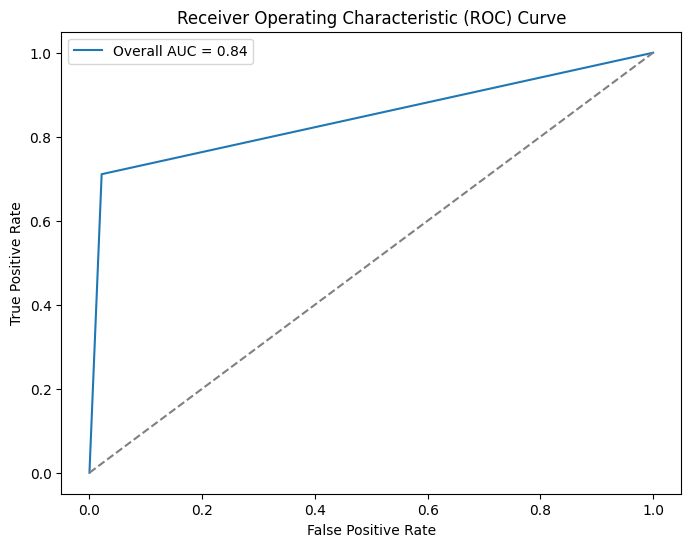

In [ ]:
drawAUC(y_true_flat, y_pred_flat)

Making predictions

In [ ]:
input_text = ["I love you"]
input_text = tokenization(input_text)
input_text
lstm_model.predict(input_text)

1/1 [==============================] - 0s 37ms/step


array([[0.10197669, 0.0004271 , 0.01378755, 0.00140351, 0.02210701,
        0.00422172]], dtype=float32)